In [6]:
%matplotlib notebook

In [1]:
import numpy as np
import gym
from collections import deque
import random
import torch.autograd
import os
import time
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import sys
import morphsim as m
from graphenvs import HalfCheetahGraphEnv
import pickle
import matplotlib.pyplot as plt
import pybullet as p 
import pybullet 
import pybullet_envs.gym_pendulum_envs 
import pybullet_envs.gym_locomotion_envs
if torch.cuda.is_available():
    device = torch.device("cuda:0")  # you can continue going on here, like cuda:1 cuda:2....etc. 
    print("Running on the GPU")
else:
    device = torch.device("cpu")
    print("Running on the CPU")
import time
import networkx as nx
import dgl

Using backend: pytorch


Running on the GPU


In [3]:
class EncoderDecoderGNN(nn.Module):
    def __init__(
        self,
        inputNetwork,
        messageNetwork,
        updateNetwork,
        outputNetwork,
        numMessagePassingIterations,
        encoder = True
    ):
        
        super(EncoderDecoderGNN, self).__init__()
                
        self.inputNetwork = inputNetwork
        self.messageNetwork = messageNetwork
        self.updateNetwork = updateNetwork
        self.outputNetwork = outputNetwork
        
        self.numMessagePassingIterations = numMessagePassingIterations
        self.encoder = encoder
        
    def inputFunction(self, nodes):
        return {'state' : self.inputNetwork(nodes.data['input'])}
    
    def messageFunction(self, edges):
        
        batchSize = edges.src['state'].shape[1]
        edgeData = edges.data['feature'].repeat(batchSize, 1).T.unsqueeze(-1)
        nodeInput = edges.src['input']
        
#         print(edges.src['state'].shape)
#         print(nodeInput.shape)
        return {'m' : self.messageNetwork(torch.cat((edges.src['state'], edgeData, nodeInput), -1))}
        

    def updateFunction(self, nodes):
        return {'state': self.updateNetwork(torch.cat((nodes.data['m_hat'], nodes.data['state']), -1))}
    
    def outputFunction(self, nodes):
        
#         numNodes, batchSize, stateSize = graph.ndata['state'].shape
#         return self.outputNetwork.forward(graph.ndata['state'])
        return {'output': self.outputNetwork(nodes.data['state'])}


    def forward(self, graph, state):
        
        self.update_states_in_graph(graph, state)
        
        graph.apply_nodes(self.inputFunction)
        
        for messagePassingIteration in range(self.numMessagePassingIterations):
            graph.update_all(self.messageFunction, dgl.function.max('m', 'm_hat'), self.updateFunction)
        
        graph.apply_nodes(self.outputFunction)
        
        output = graph.ndata['output']
        
        return output
    
    def update_states_in_graph(self, graph, state):
        
        if self.encoder:
            if len(state.shape) == 1:
                state = state.unsqueeze(0)

            numGraphFeature = 6
            numGlobalStateInformation = 5
            numLocalStateInformation = 2
            numStateVar = state.shape[1]
            globalInformation = state[:, 0:5]
            batch_size = state.shape[0]
            numNodes = (numStateVar - 5) // 2

            nodeData = torch.empty((numNodes, batch_size, numGraphFeature + numGlobalStateInformation + numLocalStateInformation)).to(device)

            nodeData[:, :, 0:numGlobalStateInformation] = globalInformation            
            for nodeIdx in range(numNodes):
                # Assign local state information
                nodeData[nodeIdx, :, numGlobalStateInformation] = state[:, 5 + nodeIdx]
                nodeData[nodeIdx, :, numGlobalStateInformation + 1] = state[:, 5 + numNodes + nodeIdx]
                # Assign global features from graph
                nodeData[nodeIdx, :, numGlobalStateInformation + 2 : numGlobalStateInformation + 2 + numGraphFeature] = graph.ndata['feature'][nodeIdx]

            graph.ndata['input'] = nodeData
        
        else:
            numNodes, batchSize, inputSize = state.shape
            nodeData = torch.empty((numNodes, batchSize, inputSize + 6)).to(device)
            nodeData[:, :, :inputSize] = state
            nodeData[:, :, inputSize : inputSize + 6] = graph.ndata['feature'].unsqueeze(dim=1).repeat_interleave(batchSize, dim=1)
#             for nodeIdx in range(numNodes):
#                 nodeData[nodeIdx, :, inputSize : inputSize + 6] = graph.ndata['feature'][nodeIdx]
            
            graph.ndata['input'] = nodeData
        

In [4]:
class InverseDynamicsGNN(nn.Module):
    def __init__(
        self,
        inputNetwork,
        messageNetwork,
        updateNetwork,
        outputNetwork,
        numMessagePassingIterations,
        withInputNetwork = True
    ):
        
        super(InverseDynamicsGNN, self).__init__()
                
        self.inputNetwork = inputNetwork
        self.messageNetwork = messageNetwork
        self.updateNetwork = updateNetwork
        self.outputNetwork = outputNetwork
        
        self.numMessagePassingIterations = numMessagePassingIterations
        self.withInputNetwork = withInputNetwork
        
    def inputFunction(self, nodes):
        return {'state' : self.inputNetwork(nodes.data['input'])}
    
    def messageFunction(self, edges):
        
        batchSize = edges.src['state'].shape[1]
        edgeData = edges.data['feature'].repeat(batchSize, 1).T.unsqueeze(-1)
        nodeInput = edges.src['input']
        
        return {'m' : self.messageNetwork(torch.cat((edges.src['state'], edgeData, nodeInput), -1))}
    
    def updateFunction(self, nodes):
        return {'state': self.updateNetwork(torch.cat((nodes.data['m_hat'], nodes.data['state']), -1))}
    
    def outputFunction(self, nodes):
        
#         numNodes, batchSize, stateSize = graph.ndata['state'].shape
#         return self.outputNetwork.forward(graph.ndata['state'])
        return {'output': self.outputNetwork(nodes.data['state'])}


    def forward(self, graph, state):
        
        self.update_states_in_graph(graph, state)
        
        if self.withInputNetwork:
            graph.apply_nodes(self.inputFunction)
        
        for messagePassingIteration in range(self.numMessagePassingIterations):
            graph.update_all(self.messageFunction, dgl.function.mean('m', 'm_hat'), self.updateFunction)
        
        graph.apply_nodes(self.outputFunction)
        
        output = graph.ndata['output']
        output = torch.transpose(output, dim0=0, dim1=1)
        output = torch.squeeze(output, dim=-1)

        return output
    
    def update_states_in_graph(self, graph, state):
        if len(state.shape) == 1:
            state = state.unsqueeze(0)
        
        numGraphFeature = 6
        numGlobalStateInformation = 5
        numLocalStateInformation = 2
        numStateVar = state.shape[1] // 2
        globalInformation = torch.cat((state[:, 0:5], state[:, numStateVar:numStateVar+5]), -1)
        
        numNodes = (numStateVar - 5) // 2

        nodeData = torch.empty((numNodes, state.shape[0], numGraphFeature + 2 * numGlobalStateInformation + 2 * numLocalStateInformation)).to(device)
        for nodeIdx in range(numNodes):

            # Assign global features from graph
            nodeData[nodeIdx, :, :6] = graph.ndata['feature'][nodeIdx]
            # Assign local state information
            nodeData[nodeIdx, :, 16] = state[:, 5 + nodeIdx]
            nodeData[nodeIdx, :, 17] = state[:, 5 + numNodes + nodeIdx]
            nodeData[nodeIdx, :, 18] = state[:, numStateVar + 5 + nodeIdx]
            nodeData[nodeIdx, :, 19] = state[:, numStateVar + 5 + numNodes + nodeIdx]

        # Assdign global state information
        nodeData[:, :, 6:16] = globalInformation
        
        if self.withInputNetwork:
            graph.ndata['input'] = nodeData        
        
        else:
            graph.ndata['state'] = nodeData

In [5]:
class gnnNetwork(nn.Module):
    def __init__(
        self,
        input_size,
        output_size,
        hidden_sizes,
        with_batch_norm=False,
        activation=None
    ):
        super(gnnNetwork, self).__init__()
        self.hidden_sizes = hidden_sizes
        self.input_size = input_size
        self.output_size = output_size
        
        self.layers = nn.ModuleList()

        self.layers.append(nn.Linear(self.input_size, hidden_sizes[0]))
        if with_batch_norm:
            self.layers.append(nn.LayerNorm(normalized_shape=(hidden_sizes[0])))
        self.layers.append(nn.ReLU())
        
        for i in range(len(hidden_sizes) - 1):
            self.layers.append(nn.Linear(hidden_sizes[i], hidden_sizes[i+1]))
            if with_batch_norm:
                self.layers.append(nn.LayerNorm(normalized_shape=(hidden_sizes[i+1])))
            self.layers.append(nn.ReLU())
        
        self.layers.append(nn.Linear(hidden_sizes[len(hidden_sizes) - 1], self.output_size))
        
        if activation is not None:
            self.layers.append(activation())
            
    def forward(self, x):
        out = x
        
        for layer in self.layers:
            out = layer(out)
            
        return out

In [6]:
class QValue(nn.Module):
    def __init__(
        self,
        input_size_state,
        input_size_action,
        hidden_sizes
    ):
        super(QValue, self).__init__()
        self.hidden_sizes = hidden_sizes
        self.input_size = input_size_action + input_size_state
        
        self.layers = nn.ModuleList()
        
        self.layers.append(nn.Linear(self.input_size, hidden_sizes[0]))
        self.layers.append(nn.ReLU())
        
        for i in range(len(hidden_sizes) - 1):
            self.layers.append(nn.Linear(hidden_sizes[i], hidden_sizes[i+1]))
            self.layers.append(nn.ReLU())
        
        self.layers.append(nn.Linear(hidden_sizes[len(hidden_sizes) - 1], 1))
        
    def forward(self, state, action):
        x = torch.cat([state, action], 1)
        
        for layer in self.layers:
            x = layer(x)
            
        return x

In [7]:
class Policy(nn.Module):
    def __init__(
        self,
        input_size_state,
        hidden_sizes,
        output_size
    ):
        super(Policy, self).__init__()
        self.hidden_sizes = hidden_sizes
        self.input_size = input_size_state
        
        self.layers = nn.ModuleList()
        
        self.layers.append(nn.Linear(self.input_size, hidden_sizes[0]))
        self.layers.append(nn.ReLU())
        
        for i in range(len(hidden_sizes) - 1):
            self.layers.append(nn.Linear(hidden_sizes[i], hidden_sizes[i+1]))
            self.layers.append(nn.ReLU())
        
        self.layers.append(nn.Linear(hidden_sizes[len(hidden_sizes) - 1], output_size))
        self.layers.append(nn.Tanh())
        
    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

In [8]:
class DDPGagent:
    def __init__(self, env, q_hidden_sizes=[32, 64, 128, 64, 32], p_hidden_sizes=[32, 64, 128, 64, 32], actor_learning_rate=1e-3, critic_learning_rate=1e-3, gamma=0.99, tau=1e-2, max_memory_size=int(1e6)):
        # Params
        self.num_states = env.observation_space.shape[0]
        self.num_actions = env.action_space.shape[0]
        self.gamma = gamma
        self.tau = tau

        # Networks

        self.actor = Policy(self.num_states, p_hidden_sizes, self.num_actions).to(device)
        self.actor_target = Policy(self.num_states, p_hidden_sizes, self.num_actions).to(device)
        self.critic = QValue(self.num_states, self.num_actions, q_hidden_sizes).to(device)
        self.critic_target = QValue(self.num_states, self.num_actions, q_hidden_sizes).to(device)
        
        for target_param, param in zip(self.actor_target.parameters(), self.actor.parameters()):
            target_param.data.copy_(param.data)

        for target_param, param in zip(self.critic_target.parameters(), self.critic.parameters()):
            target_param.data.copy_(param.data)
        
        # Training
        self.memory = Memory(max_memory_size)
        self.critic_criterion  = nn.MSELoss()
        self.actor_optimizer  = optim.Adam(self.actor.parameters(), lr=actor_learning_rate)
        self.critic_optimizer = optim.Adam(self.critic.parameters(), lr=critic_learning_rate)
        lmbda = lambda epoch: 0.8
        self.actor_lr_scheduler = optim.lr_scheduler.MultiplicativeLR(self.actor_optimizer, lr_lambda=lmbda)
        self.critic_lr_scheduler = optim.lr_scheduler.MultiplicativeLR(self.actor_optimizer, lr_lambda=lmbda)

    def get_action(self, state):
        state = torch.from_numpy(state).float().to(device)
        action = self.actor.forward(state)
        return action.cpu().detach().numpy()
    
    def get_latest_lr(self):
        return self.critic_lr_scheduler.get_last_lr()
    
    def update_lr(self):
        self.critic_lr_scheduler.step()
        self.actor_lr_scheduler.step()
    
    def update(self, batch_size):
        states, actions, rewards, next_states, _ = self.memory.sample(batch_size)
        states = torch.FloatTensor(states).to(device)
        actions = torch.FloatTensor(actions).to(device)
        rewards = torch.FloatTensor(rewards).to(device)
        next_states = torch.FloatTensor(next_states).to(device)
    
        # Critic loss        
        Qvals = self.critic.forward(states, actions)
        next_actions = self.actor_target.forward(next_states)
        next_Q = self.critic_target.forward(next_states, next_actions.detach())
        Qprime = rewards + self.gamma * next_Q
        critic_loss = self.critic_criterion(Qvals, Qprime)

        # Actor loss
        policy_loss = -self.critic.forward(states, self.actor.forward(states)).mean()
        
        # update networks
        self.actor_optimizer.zero_grad()
        policy_loss.backward()
        self.actor_optimizer.step()
        
        self.critic_optimizer.zero_grad()
        critic_loss.backward() 
        self.critic_optimizer.step()
        
        # update target networks 
        for target_param, param in zip(self.actor_target.parameters(), self.actor.parameters()):
            target_param.data.copy_(param.data * self.tau + target_param.data * (1.0 - self.tau))

        for target_param, param in zip(self.critic_target.parameters(), self.critic.parameters()):
            target_param.data.copy_(param.data * self.tau + target_param.data * (1.0 - self.tau))
            
    def save_agent_networks(self, prefix):
        torch.save(self.actor, prefix + '-actor.pt')
        torch.save(self.critic, prefix + '-critic.pt')
        
    def load_agent_networks(self, prefix):
        self.actor = torch.load(prefix + '-actor.pt').to(device)
        self.critic = torch.load(prefix + '-critic.pt').to(device)
        self.actor_target = self.actor
        self.critic_target = self.critic
        

In [9]:
class Memory:
    def __init__(self, max_size):
        self.max_size = max_size
        self.buffer = deque(maxlen=max_size)
    
    def push(self, state, action, reward, next_state, done):
        experience = (state, action, np.array([reward]), next_state, done)
        self.buffer.append(experience)

    def sample(self, batch_size):
        state_batch = []
        action_batch = []
        reward_batch = []
        next_state_batch = []
        done_batch = []

        batch = random.sample(self.buffer, batch_size)

        for experience in batch:
            state, action, reward, next_state, done = experience
            state_batch.append(state)
            action_batch.append(action)
            reward_batch.append(reward)
            next_state_batch.append(next_state)
            done_batch.append(done)
        
        return state_batch, action_batch, reward_batch, next_state_batch, done_batch

    def __len__(self):
        return len(self.buffer)

In [10]:
# Encoder / Decoder Definitions

hidden_sizes = [256, 256]

inputSize = 13
stateSize = 64
messageSize = 64
latentSize = 4
numMessagePassingIterations = 6
with_batch_norm = True

# # Encoder Networks 
encoderInputNetwork = gnnNetwork(inputSize, stateSize, hidden_sizes, with_batch_norm=with_batch_norm)
encoderMessageNetwork = gnnNetwork(stateSize + inputSize + 1, messageSize, hidden_sizes, with_batch_norm=with_batch_norm, activation=nn.Tanh)
encoderUpdateNetwork = gnnNetwork(stateSize + messageSize, stateSize, hidden_sizes, with_batch_norm=with_batch_norm)
encoderOutputNetwork = gnnNetwork(stateSize, latentSize, hidden_sizes, with_batch_norm=with_batch_norm, activation=nn.Tanh)
encoderGNN = EncoderDecoderGNN(encoderInputNetwork, encoderMessageNetwork, encoderUpdateNetwork, encoderOutputNetwork, numMessagePassingIterations, encoder=True).to(device)

# # Decoder Networks
decoderInputNetwork = gnnNetwork(latentSize + 6, stateSize, hidden_sizes, with_batch_norm=with_batch_norm)
decoderMessageNetwork = gnnNetwork(stateSize + latentSize + 7, messageSize, hidden_sizes, with_batch_norm=with_batch_norm, activation=nn.Tanh)
decoderUpdateNetwork = gnnNetwork(stateSize + messageSize, stateSize, hidden_sizes, with_batch_norm=with_batch_norm)
decoderOutputNetwork = gnnNetwork(stateSize, 7, hidden_sizes, with_batch_norm=with_batch_norm)
decoderGNN = EncoderDecoderGNN(decoderInputNetwork, decoderMessageNetwork, decoderUpdateNetwork, decoderOutputNetwork, numMessagePassingIterations, encoder=False).to(device)

encoderGNN.load_state_dict(torch.load('autoencoder-multitask/latent-4-alpha-0.25/encoderGNN-normalized-time-contrastive-latent-4.pt'))
decoderGNN.load_state_dict(torch.load('autoencoder-multitask/latent-4-alpha-0.25/decoderGNN-normalized-time-contrastive-latent-4.pt'))

<All keys matched successfully>

In [11]:
# Inverse Dynamics Definition

hidden_sizes = [256, 256]

inputSize = 20
stateSize = 64
messageSize = 64
outputSize = 1
numMessagePassingIterations = 6
with_batch_norm=True

inputNetwork = gnnNetwork(inputSize, stateSize, hidden_sizes, with_batch_norm)
messageNetwork = gnnNetwork(stateSize + inputSize + 1, messageSize, hidden_sizes, with_batch_norm, nn.Tanh)
updateNetwork = gnnNetwork(stateSize + messageSize, stateSize, hidden_sizes, with_batch_norm)
outputNetwork = gnnNetwork(stateSize, outputSize, hidden_sizes, with_batch_norm, nn.Tanh)

inverseDynamicsGNN = InverseDynamicsGNN(inputNetwork, messageNetwork, updateNetwork, outputNetwork, numMessagePassingIterations).to(device)
inverseDynamicsGNN.load_state_dict(torch.load('inverse-dynamics-multitask/hidden-256-msgpass-6-layer-norm/inverseModel-GNN.pt'))

<All keys matched successfully>

In [25]:
idx = 6
env = HalfCheetahGraphEnv(None)
env.set_morphology(idx)

agent = DDPGagent(env)
agent.load_agent_networks('{}-new-halfCheetah'.format(idx))
states, actions, rewards, next_states, dones = [], [], [], [], []
episodeReward = 0
state = env.reset()

for i in range(500):
    
    time.sleep(0.05)
    env._current_env._pb_env.camera_adjust()
    action = agent.get_action(state)
#     action = np.clip(action + np.random.normal(0, 0.1, env.action_space.shape), -1, 1)
    next_state, reward, done, _ = env.step(action)
    episodeReward += reward
    states.append(state)
    actions.append(action)
    rewards.append(reward)
    next_states.append(next_state)
    dones.append(done)

    state = next_state

print(episodeReward)
env._current_env.close()


NoneType: None


None
*************************************************************************************************************


RuntimeError: unknown parameter type

In [20]:
states = np.stack(states)
next_states = np.stack(next_states)
actions = np.stack(actions)
rewards = np.stack(rewards)

In [21]:
g1 = env.get_graph()._get_dgl_graph()
g2 = env.get_graph()._get_dgl_graph()
latents = encoderGNN(g1, torch.from_numpy(states))
reconstruction = decoderGNN(g2, latents)

print(nn.MSELoss()(reconstruction, g1.ndata['input'][:, :, :7]))

tensor(2.7980, device='cuda:0', grad_fn=<MseLossBackward>)


In [17]:
reconstruction.shape

torch.Size([5, 500, 7])

[0.36417759 0.24516355 0.0654259  0.06638225 0.0222391  0.29321687
 0.02454164 0.11899147 0.3425081  0.08623081 0.18696948 0.15394925
 0.00224571 0.02624472 0.12213505 0.18155459 0.02834146 0.02506779
 0.10721924 0.1053487  0.04968313 0.15330568 0.15446664 0.32019426
 0.00112313 0.04838913 0.11111538 0.07935095 0.15671746 0.12874106
 0.04378467 0.1388304  0.01439833 0.23721855 0.01515208 0.23449207
 0.32735576 0.23672435 0.0151656  0.09309287 0.00730454 0.36434381
 0.16612481 0.1867489  0.16698768 0.14532094 0.31197758 0.07979779
 0.09481247 0.00195451 0.18441043 0.07750642 0.18681883 0.35416354
 0.00519767 0.11494361 0.15200266 0.12005282 0.19925133 0.25342987
 0.03116277 0.16829075 0.28011005 0.23660217 0.01303843 0.07705517
 0.19316683 0.04488263 0.03736317 0.30213026 0.02977668 0.21134465
 0.10231804 0.12422539 0.00046819 0.00350632 0.12389548 0.0145238
 0.19023252 0.16932343 0.03874578 0.07179564 0.13383329 0.15724417
 0.29791526 0.0212116  0.00233748 0.26330235 0.01669077 0.05143

<IPython.core.display.Javascript object>


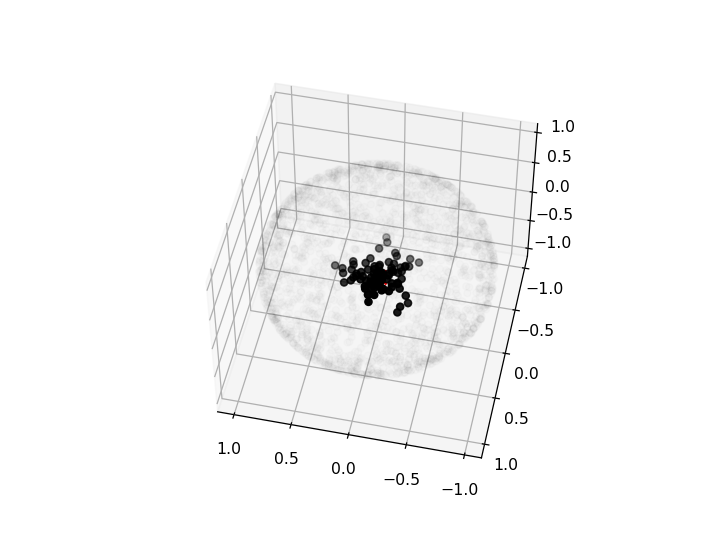

In [16]:
random_encoding = np.random.normal(size=(3))
random_encoding /= np.linalg.norm(random_encoding)

# Randomly sample points on sphere, only included for ilustration purposes
num_base_points = 2048
base_sphere_points = np.random.normal(size=(num_base_points, 3))
base_sphere_points /= np.linalg.norm(base_sphere_points, axis=-1)[:, np.newaxis]

# Define target point

# Randomly sample within alpha distance of point (i.e. within the sphere with centre base point and radius alpha)
alpha = 0.4
num_offsets = 100

offsets = np.random.normal(size=(num_offsets, 3)) 
offsets /= np.linalg.norm(offsets, axis=-1)[:, np.newaxis]
offsets *= np.random.uniform(low=0, high=alpha, size=num_offsets)[:, np.newaxis]

# Convert coordinates from sphere into global ones, and project onto original sphere
new_points = random_encoding - offsets
new_points /= np.linalg.norm(new_points, axis=-1)[:, np.newaxis]

print(np.linalg.norm(new_points - random_encoding, axis=-1))

fig = plt.figure()

# new_states = decoderGNN(g, torch.from_numpy(new_points))
ax = plt.axes(projection ='3d')
ax.scatter3D(new_points[:, 0], new_points[:, 1], new_points[:,2], c='black')
ax.scatter3D(base_sphere_points[:, 0], base_sphere_points[:, 1], base_sphere_points[:,2], c='black', alpha=0.01)
ax.scatter3D(random_encoding[0], random_encoding[1], random_encoding[2], c='red', marker='x', s=80)
plt.show()